In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [15]:
data = pd.read_csv('/Users/abhijitdeshpande/Documents/Project/final_data.csv')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2653 entries, 0 to 2652
Data columns (total 67 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SMA               2653 non-null   float64
 1   EMA               2653 non-null   float64
 2   MACD_Hist         2653 non-null   float64
 3   MACD_Signal       2653 non-null   float64
 4   MACD              2653 non-null   float64
 5   SlowD             2653 non-null   float64
 6   SlowK             2653 non-null   float64
 7   RSI               2653 non-null   float64
 8   ADX               2653 non-null   float64
 9   CCI               2653 non-null   float64
 10  Aroon Up          2653 non-null   float64
 11  Aroon Down        2653 non-null   float64
 12  Chaikin A/D       2653 non-null   float64
 13  OBV               2653 non-null   float64
 14  Real Middle Band  2653 non-null   float64
 15  Real Upper Band   2653 non-null   float64
 16  Real Lower Band   2653 non-null   float64


In [4]:
data.index = data.date

In [11]:
def get_Daily_Volatility(close,span0=20):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0

In [12]:
def get_atr(stock, win=14):
    
    atr_df = pd.Series(index=stock.index)
    high = pd.Series(adj.high.rolling( \
                     win, min_periods=win))
    low = pd.Series(adj.low.rolling( \
                    win, min_periods=win))
    close = pd.Series(adj.close.rolling( \
                      win, min_periods=win))    
          
    for i in range(len(stock.index)):
        tr=np.max([(high[i] - low[i]), \
                  np.abs(high[i] - close[i]), \
                  np.abs(low[i] - close[i])], \
                  axis=0)
        atr_df[i] = tr.sum() / win
     
    return  atr_df

In [13]:
def get_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 
              'price', 'vert_barrier', \
              'top_barrier', 'bottom_barrier'], \
               index = daily_volatility.index)
    for day, vol in daily_volatility.iteritems():
        days_passed = len(daily_volatility.loc \
                      [daily_volatility.index[0] : day])
        #set the vertical barrier 
        if ((days_passed + t_final) < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)
        barriers.loc[day, ['days_passed', 'price', 
            'vert_barrier','top_barrier', 'bottom_barrier']] = \
             days_passed, prices.loc[day], vert_barrier, \
             top_barrier, bottom_barrier
    return barriers

In [14]:
#set the boundary of barriers, based on 20 days EWM
daily_volatility = get_Daily_Volatility(data.close)
# how many days we hold the stock which set the vertical barrier
t_final = 5
#the up and low boundary multipliers
upper_lower_multipliers = [1, 1]
#allign the index
prices = data.close[daily_volatility.index]

AttributeError: 'DataFrame' object has no attribute 'close'

In [9]:
barriers = get_barriers()

NameError: name 'daily_volatility' is not defined

In [10]:
barriers.info()

NameError: name 'barriers' is not defined

In [14]:
barriers['out'] = None
barriers.head()

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
date,,,,,,
2011-04-15,1,5.116,2011-04-26,5.148842,5.083158,None
2011-04-18,2,5.006,2011-04-27,5.111059,4.900941,None
2011-04-19,3,5.032,2011-04-28,5.116934,4.947066,None
2011-04-20,4,5.15,2011-04-29,5.240737,5.059263,None
2011-04-21,5,5.348,2011-05-02,5.45933,5.23667,None


In [15]:
def get_labels():
 
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
            # assign the initial and final price
            price_initial = barriers.price[start]
            price_final = barriers.price[end]
            # assign the top and bottom barriers
            top_barrier = barriers.top_barrier[i]
            bottom_barrier = barriers.bottom_barrier[i]
            #set the profit taking and stop loss conditons
            condition_pt = (barriers.price[start: end] >= \
             top_barrier).any()
            condition_sl = (barriers.price[start: end] <= \
             bottom_barrier).any()
            #assign the labels
            if condition_pt: 
                barriers['out'][i] = 1
            elif condition_sl: 
                barriers['out'][i] = -1    
            else: 
                barriers['out'][i] = max(
                          [(price_final - price_initial)/ 
                           (top_barrier - price_initial), \
                           (price_final - price_initial)/ \
                           (price_initial - bottom_barrier)],\
                            key=abs)
                #barriers['out'][i] = 0
    return 
get_labels()

In [16]:
barriers['vert_barrier'] = barriers['vert_barrier'].map(lambda x:x)
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
date,,,,,,
2011-04-15,1,5.116,2011-04-26,5.148842,5.083158,1
2011-04-18,2,5.006,2011-04-27,5.111059,4.900941,1
2011-04-19,3,5.032,2011-04-28,5.116934,4.947066,1
2011-04-20,4,5.15,2011-04-29,5.240737,5.059263,1
2011-04-21,5,5.348,2011-05-02,5.45933,5.23667,1
...,...,...,...,...,...,...
2021-04-21,2520,744.12,NaN,772.155134,716.084866,None
2021-04-22,2521,719.69,NaN,746.864367,692.515633,None
2021-04-23,2522,729.4,NaN,755.699903,703.100097,None


In [17]:
barriers.out.value_counts()

 1.000000    1393
-1.000000     826
-0.302231       1
 0.740473       1
 0.388588       1
             ... 
 0.383283       1
 0.734734       1
-0.102836       1
-0.098753       1
-0.052990       1
Name: out, Length: 301, dtype: int64

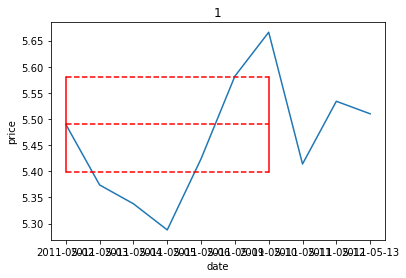

In [18]:
fig,ax = plt.subplots()
ax.set(title=barriers.out.iloc[10],
       xlabel='date', ylabel='price')
ax.plot(barriers.price[10: 20])
start = barriers.index[10]
end = barriers.vert_barrier[10]
upper_barrier = barriers.top_barrier[10]
lower_barrier = barriers.bottom_barrier[10]
ax.plot([start, end], [upper_barrier, upper_barrier], 'r--');
ax.plot([start, end], [lower_barrier, lower_barrier], 'r--');
ax.plot([start, end], [(lower_barrier + upper_barrier)*0.5, \
                       (lower_barrier + upper_barrier)*0.5], 'r--');
ax.plot([start, start], [lower_barrier, upper_barrier], 'r-');
ax.plot([end, end], [lower_barrier, upper_barrier], 'r-');

In [19]:
feature = data.drop(['date','close','out'],axis=1)

In [20]:
feature_set = pd.concat([feature,data.close,barriers[['out']]],axis=1)
feature_set.dropna(how='any',inplace=True)
label = feature_set[['out']].applymap(lambda x:1 if x>=1 else -1)

In [21]:
feature_set_ = feature_set.drop('out',axis=1)

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
scale = StandardScaler()
scaled_data = scale.fit_transform(feature_set_)

In [23]:
from sklearn.model_selection import cross_val_score
from tscv import GapKFold
from tscv import gap_train_test_split

In [24]:
X_train, X_test, y_train, y_test = gap_train_test_split(scaled_data, label, test_size=0.2, gap_size=0.05)

In [29]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf',C=1)
clf.fit(X_train,y_train)

SVC(C=1)

In [30]:
cv = GapKFold(n_splits=5, gap_before=10, gap_after=10)
scores = cross_val_score(clf, X_test, y_test, cv=cv)

In [31]:
scores.mean()

0.5686622807017543

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap='crest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
def getWeights(d,size):
    # thres>0 drops insignificant weights
    w=[1.]
    for k in range(1,size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w 

#getWeights(0.1, s_.shape[0])

In [34]:
getWeights(0.1, barriers.price.shape[0])

array([[-1.69462519e-05],
       [-1.69536435e-05],
       [-1.69610413e-05],
       ...,
       [-4.50000000e-02],
       [-1.00000000e-01],
       [ 1.00000000e+00]])

In [35]:
 def fracDiff(series, d, thres=0.01):
    '''
    Increasing width window, with treatment of NaNs
    Note 1: For thres=1, nothing is skipped
    Note 2: d can be any positive fractional, not necessarily
        bounded between [0,1]
    '''
    #1) Compute weights for the longest series
    w=getWeights(d, series.shape[0])
    #bp()
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_=np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF, df_=series[[name]].fillna(method='ffill').dropna(), pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc=seriesF.index[iloc]
            test_val = series.loc[loc,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc]=np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
            except:
                continue
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

In [46]:
f_d = fracDiff(data[['close']], 0.5)

<AxesSubplot:>

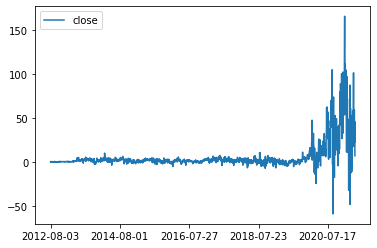

In [47]:
f_d.plot()

In [48]:
barriers.price.shape, f_d.shape

((2524,), (2196, 1))

In [49]:
feature_set = pd.concat([feature,barriers[['out']],f_d],axis=1)
feature_set.dropna(how='any',inplace=True)
label = feature_set[['out']].applymap(lambda x:1 if x>=1 else 0)

In [50]:
feature_set_ = feature_set.drop('out',axis=1)

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
scale = StandardScaler()
scaled_data = scale.fit_transform(feature_set_)

In [52]:
from sklearn.model_selection import cross_val_score
from tscv import GapKFold
from tscv import gap_train_test_split

In [53]:
X_train, X_test, y_train, y_test = gap_train_test_split(scaled_data, label, test_size=0.2, gap_size=0.05)

In [54]:
from sklearn.svm import SVC
clf = SVC(kernel='poly',degree=2,C=1)
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)
accuracy_score(prediction, y_test)

0.5600961538461539

In [55]:
print(classification_report(prediction,y_test))

              precision    recall  f1-score   support

           0       0.37      0.43      0.40       139
           1       0.69      0.62      0.65       277

    accuracy                           0.56       416
   macro avg       0.53      0.53      0.53       416
weighted avg       0.58      0.56      0.57       416



In [56]:
cv = GapKFold(n_splits=10, gap_before=5, gap_after=5)
scores = cross_val_score(clf, X_test, y_test, cv=cv)

In [47]:
import alpha_vantage
api_key = 'SXJIW6MO6ZIEYB0N'
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries

In [48]:
ts = TimeSeries(key=api_key, output_format='pandas')

In [49]:
def technical_features(technical_feature,company='TSLA', interval='daily', period=200, series_type='Close'):
    data, meta_data = technical_feature(company, interval=interval, time_period= period, series_type=series_type)
    return data

def other_features(technical_feature,company='TSLA', interval='daily'):
    data, meta_data = technical_feature(company, interval=interval)
    return data

In [50]:
adj, meta = ts.get_daily('TSLA',outputsize='full')
adj['time'] = adj.index
adj.rename(columns={'4. close':'close', '2. high':'high','3. low':'low','1. open':'open', '5. volume':'vol'},inplace=True)
close = adj[['close']]

<AxesSubplot:xlabel='date'>

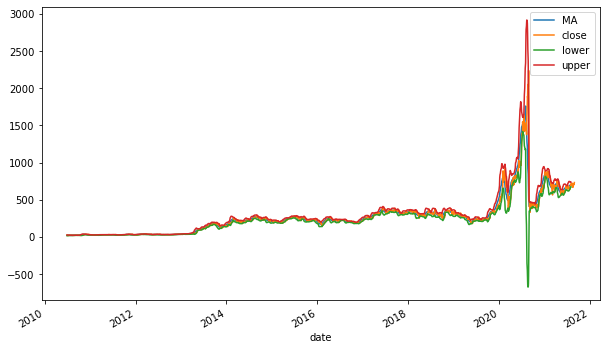

In [51]:
close['MA'] = ((adj['close']+adj['high']+adj['low'])/3).rolling(window=20).mean()
close['std'] = ((adj['close']+adj['high']+adj['low'])/3).rolling(window=20).std()
close['lower'] = close['MA']-(close['std']*2)
close['upper'] = close['MA']+(close['std']*2)
close[['MA','close','lower','upper']].plot(figsize=(10,6))

In [52]:
f_d.index = pd.to_datetime(f_d.index)
close = pd.concat([close,f_d],axis=1).dropna()

<AxesSubplot:>

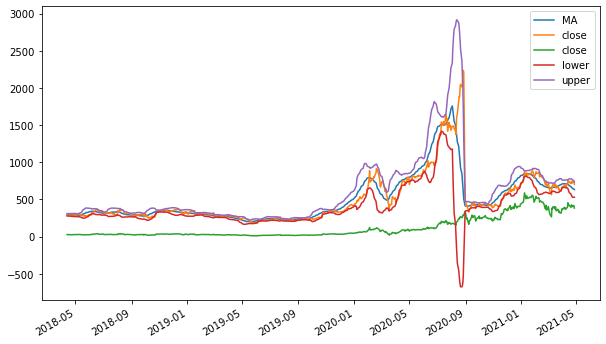

In [53]:
close['MA'] = ((adj['close']+adj['high']+adj['low'])/3).rolling(window=20).mean()
close['std'] = ((adj['close']+adj['high']+adj['low'])/3).rolling(window=20).std()
close['lower'] = close['MA']-(close['std']*2)
close['upper'] = close['MA']+(close['std']*2)
close[['MA','close','lower','upper']].plot(figsize=(10,6))

In [ ]:
import numpy
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import MaxPooling1D as MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
import tensorflow.keras.layers as tfl

In [96]:
data.columns

Index(['date', 'SMA', 'EMA', 'MACD', 'MACD_Signal', 'MACD_Hist', 'SlowK',
       'SlowD', 'RSI', 'ADX', 'CCI', 'Aroon Down', 'Aroon Up', 'Chaikin A/D',
       'OBV', 'Real Lower Band', 'Real Upper Band', 'Real Middle Band', 'WMA',
       'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA', 'FAMA', 'T3', 'MACD.1',
       'MACD_Hist.1', 'MACD_Signal.1', 'FastK', 'FastD', 'FastD.1', 'FastK.1',
       'WILLR', 'ADXR', 'APO', 'PPO', 'MOM', 'BOP', 'CMO', 'ROC', 'ROCR',
       'AROONOSC', 'MFI', 'TRIX', 'ULTOSC', 'DX', 'MINUS_DI', 'PLUS_DI',
       'MINUS_DM', 'PLUS_DM', 'MIDPOINT', 'MIDPRICE', 'SAR', 'TRANGE', 'ATR',
       'NATR', 'HT_TRENDLINE', 'SINE', 'LEAD SINE', 'TRENDMODE', 'DCPERIOD',
       'HT_DCPHASE', 'PHASE', 'QUADRATURE', 'close', 'out'],
      dtype='object')

In [97]:
new_data = data[['SMA','MACD','T3','OBV','ADX','Aroon Up','Aroon Down','RSI','close','out']]

In [98]:
df = data.drop(['date','out'],axis=1)

In [99]:
data_1 = new_data.drop(['out'],axis=1)

In [100]:
label = data[['out']].applymap(lambda x:1 if x>=1 else 0)
#label = new_data['close']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [101]:
#data_reshaped = scaled_data.reshape(2526,1,9)

In [102]:
df.shape

(2526, 65)

In [1]:
import torch

In [103]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([ 846, 1048]))

In [104]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df,label,test_size=0.25,shuffle=False)

In [105]:
X_train.shape

(577, 65)

In [7]:
model = keras.Sequential()
model.add(tfl.Dense(100, input_dim=65, activation='relu'))
model.add(tfl.Flatten())
model.add(tfl.BatchNormalization())
model.add(tfl.Dropout(0.5))
model.add(tfl.Dense(50,activation='relu'))
model.add(tfl.Dropout(0.4))
model.add(tfl.Dense(10,activation='relu'))
#model.add(Dropout(0.25))
model.add(tfl.Dense(10,activation='relu'))
model.add(tfl.Dense(6,activation='relu'))
model.add(tfl.Dense(1,activation='sigmoid'))
#model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer = 'adam',metrics=['accuracy'])
model.fit(x_train,y_train,epochs=20,batch_size=120,verbose=0)

NameError: name 'keras' is not defined

In [108]:
prediction = model.predict(x_test)

In [109]:
np.unique(prediction)

array([0.24202916, 0.2431671 , 0.24392137, 0.24403766, 0.2467078 ,
       0.24684608, 0.24724042, 0.24726367, 0.24734962, 0.2476345 ,
       0.24767873, 0.24775264, 0.24785116, 0.2482391 , 0.2482909 ,
       0.24833933, 0.24834892, 0.24845022, 0.24855405, 0.24855474,
       0.24862641, 0.24868926, 0.248752  , 0.24925026, 0.24925473,
       0.24934235, 0.24980196, 0.24997729, 0.25002092, 0.25007424,
       0.2500982 , 0.2501878 , 0.25019747, 0.25043762, 0.25086504,
       0.2509138 , 0.2510527 , 0.25128037, 0.25189894, 0.25224686,
       0.2525791 , 0.25396308, 0.25477642, 0.25716078, 0.25800905,
       0.25884593, 0.25899768, 0.260056  , 0.26181078, 0.26211947,
       0.26256928, 0.2644605 , 0.26460874, 0.2651248 , 0.26546752,
       0.26597497, 0.2669782 , 0.26749852, 0.267752  , 0.26818264,
       0.2684702 , 0.26869428, 0.26889783, 0.26930636, 0.26935163,
       0.26940596, 0.26953888, 0.2696203 , 0.26974517, 0.27017257,
       0.27082795, 0.2710947 , 0.27130112, 0.27171522, 0.27178

In [110]:
prediction

array([[0.5531725 ],
       [0.5501389 ],
       [0.5536418 ],
       [0.5485041 ],
       [0.52274364],
       [0.5010614 ],
       [0.5139566 ],
       [0.5053234 ],
       [0.49713758],
       [0.48775223],
       [0.50415784],
       [0.511628  ],
       [0.50458807],
       [0.4919755 ],
       [0.5004295 ],
       [0.5053189 ],
       [0.49725714],
       [0.49144515],
       [0.48862284],
       [0.4825215 ],
       [0.48906782],
       [0.505666  ],
       [0.5089167 ],
       [0.5114023 ],
       [0.50656056],
       [0.5178737 ],
       [0.5152869 ],
       [0.5183009 ],
       [0.5145346 ],
       [0.5009945 ],
       [0.48874557],
       [0.48037145],
       [0.48780367],
       [0.482965  ],
       [0.47404486],
       [0.4790912 ],
       [0.47366932],
       [0.4787866 ],
       [0.48630333],
       [0.49298787],
       [0.5007277 ],
       [0.50806093],
       [0.4989937 ],
       [0.5014319 ],
       [0.49748695],
       [0.5123521 ],
       [0.5047639 ],
       [0.513

In [111]:
results = []
for i in prediction:
    if i>0.5:
        results.append(1)
    else:
        results.append(0)

In [112]:
np.unique(results, return_counts=True)

(array([0, 1]), array([331, 301]))

In [113]:
y_test.value_counts()

out
1      343
0      289
dtype: int64

In [114]:
print(classification_report(results,y_test))

              precision    recall  f1-score   support

           0       0.53      0.47      0.50       331
           1       0.48      0.55      0.52       301

    accuracy                           0.51       632
   macro avg       0.51      0.51      0.51       632
weighted avg       0.51      0.51      0.51       632



In [115]:
accuracy_score(results,y_test)

0.5063291139240507

In [116]:
results[165:175]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [117]:
y_test[165:175]

,out
date,
2019-06-20,0
2019-06-21,0
2019-06-24,0
2019-06-25,1
2019-06-26,1
2019-06-27,1
2019-06-28,1
2019-07-01,1
2019-07-02,1


In [2]:
import numpy as np
import scipy.sparse as sp
import sklearn
import sklearn.metrics
import torch
import pandas as pd
import random

def boolean_string(s):
    if s not in {'False', 'True'}:
        raise ValueError('Not a valid boolean string')
    return s == 'True'

def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot


def loaddata(filename):
    df = pd.read_csv(filename, header=None, delimiter=",")
    a = np.array(df.as_matrix())
    return a


def load_raw_ts(path, dataset, tensor_format=True):
    path = path + "raw/" + dataset + "/"
    x_train = np.load(path + 'X_train.npy')
    y_train = np.load(path + 'y_train.npy')
    x_test = np.load(path + 'X_test.npy')
    y_test = np.load(path + 'y_test.npy')
    ts = np.concatenate((x_train, x_test), axis=0)
    ts = np.transpose(ts, axes=(0, 2, 1))
    labels = np.concatenate((y_train, y_test), axis=0)
    nclass = int(np.amax(labels)) + 1


    train_size = y_train.shape[0]

    total_size = labels.shape[0]
    idx_train = range(train_size)
    idx_val = range(train_size, total_size)
    idx_test = range(train_size, total_size)

    if tensor_format:
        # features = torch.FloatTensor(np.array(features))
        ts = torch.FloatTensor(np.array(ts))
        labels = torch.LongTensor(labels)

        idx_train = torch.LongTensor(idx_train)
        idx_val = torch.LongTensor(idx_val)
        idx_test = torch.LongTensor(idx_test)

    return ts, labels, idx_train, idx_val, idx_test, nclass


def normalize(mx):
    """Row-normalize sparse matrix"""
    row_sums = mx.sum(axis=1)
    mx = mx.astype('float32')
    row_sums_inverse = 1 / row_sums
    f = mx.multiply(row_sums_inverse)
    return sp.csr_matrix(f).astype('float32')


def accuracy(output, labels):
    preds = output.max(1)[1].cpu().numpy()
    labels = labels.cpu().numpy()
    accuracy_score = (sklearn.metrics.accuracy_score(labels, preds))

    return accuracy_score



def euclidean_dist(x, y):
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)


def output_conv_size(in_size, kernel_size, stride, padding):

    output = int((in_size - kernel_size + 2 * padding) / stride) + 1

    return output

def dump_embedding(proto_embed, sample_embed, labels, dump_file='/Users/abhijitdeshpande/Documents/Thesis/tapnet_converted_data/embeddings.txt'):
    proto_embed = proto_embed.cpu().detach().numpy()
    sample_embed = sample_embed.cpu().detach().numpy()
    embed = np.concatenate((proto_embed, sample_embed), axis=0)

    nclass = proto_embed.shape[0]
    labels = np.concatenate((np.asarray([i for i in range(nclass)]),
                             labels.squeeze().cpu().detach().numpy()), axis=0)

    with open(dump_file, 'w') as f:
        for i in range(len(embed)):
            label = str(labels[i])
            line = label + "," + ",".join(["%.4f" % j for j in embed[i].tolist()])
            f.write(line + '\n')

In [4]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
#from utils import euclidean_dist, normalize, output_conv_size, dump_embedding
import numpy as np

class TapNet(nn.Module):

    def __init__(self,input_data, nfeat, len_ts, nclass, dropout, filters, kernels, dilation, layers, use_rp, rp_params,
                 use_att=True, use_metric=False, use_lstm=False, use_cnn=True, lstm_dim=128):
        super(TapNet, self).__init__()
        self.nclass = nclass
        self.dropout = dropout
        self.use_metric = use_metric
        self.use_lstm = use_lstm
        self.use_cnn = use_cnn

        # parameters for random projection
        self.use_rp = use_rp
        self.rp_group, self.rp_dim = rp_params

        if True:
            # LSTM
            self.channel = nfeat
            self.ts_length = len_ts

            self.lstm_dim = lstm_dim
            self.lstm = nn.LSTM(self.ts_length, self.lstm_dim)

            paddings = [0, 0, 0]
            if self.use_rp:
                self.conv_1_models = nn.ModuleList()
                self.idx = []
                for i in range(self.rp_group):
                    self.conv_1_models.append(nn.Conv1d(self.rp_dim, filters[0], kernel_size=kernels[0], dilation=dilation, stride=1, padding=paddings[0]))
                    self.idx.append(np.random.permutation(nfeat)[0: self.rp_dim])
            else:
                self.conv_1 = nn.Conv1d(self.channel, filters[0], kernel_size=kernels[0], dilation=dilation, stride=1, padding=paddings[0])

            self.conv_bn_1 = nn.BatchNorm1d(filters[0])

            self.conv_2 = nn.Conv1d(filters[0], filters[1], kernel_size=kernels[1], stride=1, padding=paddings[1])

            self.conv_bn_2 = nn.BatchNorm1d(filters[1])

            self.conv_3 = nn.Conv1d(filters[1], filters[2], kernel_size=kernels[2], stride=1, padding=paddings[2])

            self.conv_bn_3 = nn.BatchNorm1d(filters[2])

            # compute the size of input for fully connected layers
            fc_input = 0
            if self.use_cnn:
                conv_size = len_ts
                for i in range(len(filters)):
                    conv_size = output_conv_size(conv_size, kernels[i], 1, paddings[i])
                fc_input += conv_size 
                #* filters[-1]
            if self.use_lstm:
                fc_input += conv_size * self.lstm_dim
            
            if self.use_rp:
                fc_input = self.rp_group * filters[2] + self.lstm_dim


        # Representation mapping function
        layers = [fc_input] + layers
     #   print("Layers", layers)
        self.mapping = nn.Sequential()
        for i in range(len(layers) - 2):
            self.mapping.add_module("fc_" + str(i), nn.Linear(layers[i], layers[i + 1]))
            self.mapping.add_module("bn_" + str(i), nn.BatchNorm1d(layers[i + 1]))
            self.mapping.add_module("relu_" + str(i), nn.LeakyReLU())

        # add last layer
        self.mapping.add_module("fc_" + str(len(layers) - 2), nn.Linear(layers[-2], layers[-1]))
        if len(layers) == 2:  # if only one layer, add batch normalization
            self.mapping.add_module("bn_" + str(len(layers) - 2), nn.BatchNorm1d(layers[-1]))

        # Attention
        att_dim, semi_att_dim = 128, 128
        self.use_att = use_att
        if self.use_att:
            self.att_models = nn.ModuleList()
            for _ in range(nclass):

                att_model = nn.Sequential(
                    nn.Linear(layers[-1], att_dim),
                    nn.Tanh(),
                    nn.Linear(att_dim, 1)
                )
                self.att_models.append(att_model)

        
    def forward(self, input_data):
        x, labels, idx_train, idx_val, idx_test = input_data  # x is N * L, where L is the time-series feature dimension

        if True:
            N = x.size(0)

            # LSTM
            if self.use_lstm:
                x_lstm = self.lstm(x)[0]
                x_lstm = x_lstm.mean(1)
                x_lstm = x_lstm.view(N, -1)

            if self.use_cnn:
                # Covolutional Network
                # input ts: # N * C * L
                if self.use_rp:
                    for i in range(len(self.conv_1_models)):
                        #x_conv = x
                        x_conv = self.conv_1_models[i](x[:, self.idx[i], :])
                        x_conv = self.conv_bn_1(x_conv)
                        x_conv = F.leaky_relu(x_conv)

                        x_conv = self.conv_2(x_conv)
                        x_conv = self.conv_bn_2(x_conv)
                        x_conv = F.leaky_relu(x_conv)

                        x_conv = self.conv_3(x_conv)
                        x_conv = self.conv_bn_3(x_conv)
                        x_conv = F.leaky_relu(x_conv)

                        x_conv = torch.mean(x_conv, 2)

                        if i == 0:
                            x_conv_sum = x_conv
                        else:
                            x_conv_sum = torch.cat([x_conv_sum, x_conv], dim=1)
                    x_conv = x_conv_sum
                else:
                    x_conv = x
                    x_conv = self.conv_1(x_conv)  # N * C * L
                    x_conv = self.conv_bn_1(x_conv)
                    x_conv = F.leaky_relu(x_conv)

                    x_conv = self.conv_2(x_conv)
                    x_conv = self.conv_bn_2(x_conv)
                    x_conv = F.leaky_relu(x_conv)

                    x_conv = self.conv_3(x_conv)
                    x_conv = self.conv_bn_3(x_conv)
                    x_conv = F.leaky_relu(x_conv)

                    x_conv = x_conv.view(N, -1)

            if self.use_lstm and self.use_cnn:
                x = torch.cat([x_conv, x_lstm], dim=1)
            elif self.use_lstm:
                x = x_lstm
            elif self.use_cnn:
                x = x_conv
            #

        # linear mapping to low-dimensional space
        x = self.mapping(x)

        # generate the class protocal with dimension C * D (nclass * dim)
        proto_list = []
        for i in range(self.nclass):
            idx = (labels[idx_train].squeeze() == i).nonzero().squeeze(1)
            if self.use_att:
                A = self.att_models[i](x[idx_train][idx])  # N_k * 1
                A = torch.transpose(A, 1, 0)  # 1 * N_k
                A = F.softmax(A, dim=1)  # softmax over N_k

                class_repr = torch.mm(A, x[idx_train][idx]) # 1 * L
                class_repr = torch.transpose(class_repr, 1, 0)  # L * 1
            else:  # if do not use attention, simply use the mean of training samples with the same labels.
                class_repr = x[idx_train][idx].mean(0)  # L * 1
            proto_list.append(class_repr.view(1, -1))
        x_proto = torch.cat(proto_list, dim=0)

        # prototype distance
        proto_dists = euclidean_dist(x_proto, x_proto)
        proto_dists = torch.exp(-0.5*proto_dists)
        num_proto_pairs = int(self.nclass * (self.nclass - 1) / 2)
        proto_dist = torch.sum(proto_dists) / num_proto_pairs

        dists = euclidean_dist(x, x_proto)

        dump_embedding(x_proto, x, labels)
        return torch.exp(-0.5*dists), proto_dist

In [5]:
def train(input_data,use_metric=0.001,metric_param=0.01,stop_thres = 1e-9):
    loss_list = [sys.maxsize]
    test_best_possible, best_so_far = 0.0, sys.maxsize
    for epoch in range(3000):

        t = time.time()
        tapnet.train()
        optimizer.zero_grad()

        output, proto_dist = tapnet(input_data)

        loss_train = F.cross_entropy(output[idx_train], torch.squeeze(labels[idx_train]))
        if use_metric:
            loss_train = loss_train + metric_param * proto_dist

        if abs(loss_train.item() - loss_list[-1]) < stop_thres \
                or loss_train.item() > loss_list[-1]:
            break
        else:
            loss_list.append(loss_train.item())

        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        optimizer.step()

        loss_val = F.cross_entropy(output[idx_val], torch.squeeze(labels[idx_val]))
        acc_val = accuracy(output[idx_val], labels[idx_val])

        """print('Epoch: {:04d}'.format(epoch + 1),
              'loss_train: {:.8f}'.format(loss_train.item()),
              'acc_train: {:.4f}'.format(acc_train.item()),
              'loss_val: {:.4f}'.format(loss_val.item()),
              'acc_val: {:.4f}'.format(acc_val.item()),
              'time: {:.4f}s'.format(time.time() - t))"""

        if acc_val.item() > test_best_possible:
            test_best_possible = acc_val.item()
        if best_so_far > loss_train.item():
            best_so_far = loss_train.item()
            test_acc = acc_val.item()
    #("test_acc: " + str(test_acc)),("best possible: " + str(test_best_possible))
    return round(test_acc,3), round(test_best_possible,3)


In [6]:
features, labels, idx_train, idx_val, idx_test, nclass = load_raw_ts("/Users/abhijitdeshpande/Documents/Thesis/tapnet_converted_data/tapnet_converted_data/data/", dataset = 'ArticularyWordRecognition')

In [7]:
files = ["ArticularyWordRecognition","AtrialFibrilation","BasicMotions",
"CharacterTrajectories","Cricket","DuckDuckGeese","EigenWorms","Epilepsy","ERing","EthanolConcentration",
"FaceDetection","FingerMovements","HandMovementDirection","Handwriting","Heartbeat","InsectWingbeat",
"JapaneseVowels","Libras","LSST","MotorImagery","NATOPS","PEMS-SF","PenDigits","Phoneme","RacketSports",
"SelfRegulationSCP1","SelfRegulationSCP2","SpokenArabicDigits","StandWalkJump","UWaveGestureLibrary"]

In [8]:
files = ["ArticularyWordRecognition","BasicMotions",
"CharacterTrajectories","Cricket","DuckDuckGeese","EigenWorms","Epilepsy","ERing","EthanolConcentration",
"FaceDetection","FingerMovements","HandMovementDirection","Handwriting","Heartbeat","InsectWingbeat","Libras","LSST","MotorImagery","NATOPS","PEMS-SF","Phoneme","RacketSports",
"SelfRegulationSCP1","SelfRegulationSCP2","SpokenArabicDigits","StandWalkJump","UWaveGestureLibrary"]

In [9]:
files = ['ArticularyWordRecognition','BasicMotions','CharacterTrajectories','FaceDetection','HandMovementDirection',
'Heartbeat','MotorImagery','NATOPS','PEMS-SF','Phoneme','SelfRegulationSCP2','SpokenArabicDigits','StandWalkJump']

In [10]:
for dataset in files:
    features, labels, idx_train, idx_val, idx_test, nclass = \
                    load_raw_ts("/Users/abhijitdeshpande/Documents/Thesis/tapnet_converted_data/tapnet_converted_data/data/",
                                                                      dataset = dataset)
    #print(dataset)
    #print(features.shape,'\n')

In [11]:
import sys

In [172]:
optimizer = optim.Adam(tapnet.parameters(),
                      lr=1e-5, weight_decay=1e-3)

In [173]:
from numpy import vstack as vstack

In [174]:
list_ = [np.array(['Dataset','Test_acc','Best_acc', 'Time'])]
for dataset in files:
        features, labels, idx_train, idx_val, idx_test, nclass = \
                        load_raw_ts("/Users/abhijitdeshpande/Documents/Thesis/tapnet_converted_data/tapnet_converted_data/data/",
                                                                      dataset = dataset)
    
        input_data = features, labels, idx_train, idx_val, idx_test
    

        tapnet = TapNet(input_data = input_data,
                   nfeat=features.shape[1],
                   len_ts=features.shape[2],
                   layers=[500,300],
                   nclass=nclass,
                   dropout=0.5,
                   use_lstm=True,
                   use_cnn=True,
                   filters=(256,256,128),
                   dilation=1,
                   kernels=(8,5,3),
                   use_metric=0.001,
                   use_rp=True,
                   rp_params=(1,3),
                   lstm_dim=128)

        start = time.time()
        reults = train(input_data)
        end = time.time()
        total_time = end - start
        res = np.array([dataset,reults[0],reults[1], total_time])
        list_.append(res)

In [175]:
pd.DataFrame(list_[1:],columns=list_[0])

,Dataset,Test_acc,Best_acc,Time
0,ArticularyWordRecognition,0.847,0.847,8.398931980133057
1,BasicMotions,1.0,1.0,0.8341081142425537
2,CharacterTrajectories,0.971,0.971,57.23926401138306
3,FaceDetection,0.517,0.517,193.37761187553406
4,HandMovementDirection,0.324,0.324,9.212671041488647
5,Heartbeat,0.732,0.732,17.573044061660767
6,MotorImagery,0.59,0.59,141.26107907295227
7,NATOPS,0.661,0.661,2.132493019104004
8,PEMS-SF,0.324,0.324,20.480066061019897
9,Phoneme,0.126,0.126,179.22083711624146


In [176]:
for dataset in files:
        features, labels, idx_train, idx_val, idx_test, nclass = \
                        load_raw_ts("/Users/abhijitdeshpande/Documents/Thesis/tapnet_converted_data/tapnet_converted_data/data/",
                                                                      dataset = dataset)
        print([features.size()[0],features.size()[1],features.size()[2]])

[575, 9, 144]
[80, 6, 100]
[2858, 3, 182]
[9414, 62, 144]
[234, 10, 400]
[409, 61, 405]
[378, 64, 3000]
[360, 24, 51]
[440, 963, 144]
[6668, 11, 217]
[380, 7, 1152]
[8798, 13, 93]
[27, 4, 2500]


In [177]:
from collections import deque

In [178]:
np.array((3,4,56))
np.array((13,24,5))

array([13, 24,  5])

In [179]:
def test(datatset, use_metric = 0.001, metric_param = 0.01):
    features, labels, idx_train, idx_val, idx_test, nclass = \
                        load_raw_ts("/Users/abhijitdeshpande/Documents/Thesis/tapnet_converted_data/tapnet_converted_data/data/",
                                                                      dataset = dataset)
    
    input_data = features, labels, idx_train, idx_val, idx_test
    
    tapnet = TapNet(input_data = input_data,
                   nfeat=features.shape[1],
                   len_ts=features.shape[2],
                   layers=[500,300],
                   nclass=nclass,
                   dropout=0.5,
                   use_lstm=True,
                   use_cnn=True,
                   filters=(256,256,128),
                   dilation=1,
                   kernels=(8,5,3),
                   use_metric=0.001,
                   use_rp=True,
                   rp_params=(1,3),
                   lstm_dim=128)
    
    output, proto_dist = tapnet(input_data)
    loss_test = F.cross_entropy(output[idx_test], torch.squeeze(labels[idx_test]))
    if use_metric:
        loss_test = loss_test - metric_param * proto_dist

        acc_test = accuracy(output[idx_test], labels[idx_test])
        print(dataset, "Test set results:",
              "loss= {:.4f}".format(loss_test.item()),
              "accuracy= {:.4f}".format(acc_test.item()))

In [180]:
for dataset in files:
    test(dataset)

ArticularyWordRecognition Test set results: loss= 3.2076 accuracy= 0.8600
BasicMotions Test set results: loss= 1.3051 accuracy= 1.0000
CharacterTrajectories Test set results: loss= 2.9576 accuracy= 0.9680
FaceDetection Test set results: loss= 0.6534 accuracy= 0.5434
HandMovementDirection Test set results: loss= 1.3754 accuracy= 0.4054
Heartbeat Test set results: loss= 0.6662 accuracy= 0.5512
MotorImagery Test set results: loss= 0.6564 accuracy= 0.4000
NATOPS Test set results: loss= 1.7851 accuracy= 0.6556
PEMS-SF Test set results: loss= 1.9383 accuracy= 0.3584
Phoneme Test set results: loss= 3.6590 accuracy= 0.1265
SelfRegulationSCP2 Test set results: loss= 0.6622 accuracy= 0.5722
SpokenArabicDigits Test set results: loss= 2.2981 accuracy= 0.6016
StandWalkJump Test set results: loss= 1.0886 accuracy= 0.3333


In [ ]:
import tensorflow

In [3]:
pip install tsai

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


     |████████████████████████████████| 786 kB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 779 kB 21.3 MB/s eta 0:00:01
     |████████████████████████████████| 778 kB 23.6 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 18.5 MB/s eta 0:00:01
     |████████████████████████████████| 72 kB 4.0 MB/s  eta 0:00:01
  Using cached protobuf-3.11.2-cp37-cp37m-macosx_10_9_x86_64.whl (1.3 MB)
     |████████████████████████████████| 82 kB 6.1 MB/s  eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.2
    Uninstalling protobuf-3.17.2:
      Successfully uninstalled protobuf-3.17.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 3.2.1 which is incompatible.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
te

In [4]:
import tsai

In [5]:
from tsai.imports import *
#from tsai.data.external import *
from tsai.models.layers import *

In [6]:
from sklearn.linear_model import RidgeClassifierCV, RidgeCV
from sktime.transformations.panel.rocket import Rocket
from numba import njit, prange

In [186]:
#export
# This is an unofficial ROCKET implementation in Pytorch developed by Ignacio Oguiza - oguiza@gmail.com based on:
# Angus Dempster, Francois Petitjean, Geoff Webb
# Dempster A, Petitjean F, Webb GI (2019) ROCKET: Exceptionally fast and
# accurate time series classification using random convolutional kernels.
# arXiv:1910.13051
# Official repo: https://github.com/angus924/rocket

# changes: 
# - added kss parameter to generate_kernels
# - convert X to np.float64

def generate_kernels(input_length, num_kernels, kss=[7, 9, 11], pad=True, dilate=True):
    candidate_lengths = np.array((kss))
    # initialise kernel parameters
    weights = np.zeros((num_kernels, candidate_lengths.max())) # see note
    lengths = np.zeros(num_kernels, dtype = np.int32) # see note
    biases = np.zeros(num_kernels)
    dilations = np.zeros(num_kernels, dtype = np.int32)
    paddings = np.zeros(num_kernels, dtype = np.int32)
    # note: only the first *lengths[i]* values of *weights[i]* are used
    for i in range(num_kernels):
        length = np.random.choice(candidate_lengths)
        _weights = np.random.normal(0, 1, length)
        bias = np.random.uniform(-1, 1)
        if dilate: dilation = 2 ** np.random.uniform(0, np.log2((input_length - 1) // (length - 1)))
        else: dilation = 1
        if pad: padding = ((length - 1) * dilation) // 2 if np.random.randint(2) == 1 else 0
        else: padding = 0
        weights[i, :length] = _weights - _weights.mean()
        lengths[i], biases[i], dilations[i], paddings[i] = length, bias, dilation, padding
    return weights, lengths, biases, dilations, paddings

@njit(fastmath = True)
def apply_kernel(X, weights, length, bias, dilation, padding):
    # zero padding
    if padding > 0:
        _input_length = len(X)
        _X = np.zeros(_input_length + (2 * padding))
        _X[padding:(padding + _input_length)] = X
        X = _X
    input_length = len(X)
    output_length = input_length - ((length - 1) * dilation)
    _ppv = 0 # "proportion of positive values"
    _max = np.NINF
    for i in range(output_length):
        _sum = bias
        for j in range(length):
            _sum += weights[j] * X[i + (j * dilation)]
        if _sum > 0:
            _ppv += 1
        if _sum > _max:
            _max = _sum
    return _ppv / output_length, _max

@njit(parallel = True, fastmath = True)
def apply_kernels(X, kernels):
    X = X.astype(np.float64)
    weights, lengths, biases, dilations, paddings = kernels
    num_examples = len(X)
    num_kernels = len(weights)
    # initialise output
    _X = np.zeros((num_examples, num_kernels * 2)) # 2 features per kernel
    for i in prange(num_examples):
        for j in range(num_kernels):
            _X[i, (j * 2):((j * 2) + 2)] = \
            apply_kernel(X[i], weights[j][:lengths[j]], lengths[j], biases[j], dilations[j], paddings[j])
    return _X

In [187]:
from sklearn.pipeline import Pipeline

class ROCKET(nn.Module):
    """RandOm Convolutional KErnel Transform
    ROCKET is a GPU Pytorch implementation of the ROCKET functions generate_kernels
    and apply_kernels that can be used  with univariate and multivariate time series.
    """

    def __init__(self, c_in, seq_len, n_kernels=10_000, kss=[7, 9, 11], device=None, verbose=False):

        '''
        Input: is a 3d torch tensor of type torch.float32. When used with univariate TS,
        make sure you transform the 2d to 3d by adding unsqueeze(1).
        c_in: number of channels or features. For univariate c_in is 1.
        seq_len: sequence length
        '''
        super().__init__()
        device = ifnone(device, default_device())
        kss = [ks for ks in kss if ks < seq_len]
        convs = nn.ModuleList()
        for i in range(n_kernels):
            ks = np.random.choice(kss)
            dilation = 2**np.random.uniform(0, np.log2((seq_len - 1) // (ks - 1)))
            padding = int((ks - 1) * dilation // 2) if np.random.randint(2) == 1 else 0
            weight = torch.randn(1, c_in, ks)
            weight -= weight.mean()
            bias = 2 * (torch.rand(1) - .5)
            layer = nn.Conv1d(c_in, 1, ks, padding=2 * padding, dilation=int(dilation), bias=True)
            layer.weight = torch.nn.Parameter(weight, requires_grad=False)
            layer.bias = torch.nn.Parameter(bias, requires_grad=False)
            convs.append(layer)
        self.convs = convs
        self.n_kernels = n_kernels
        self.kss = kss
        self.to(device=device)
        self.verbose=verbose

    def forward(self, x):
        _output = []
        for i in progress_bar(range(self.n_kernels), display=self.verbose, leave=False, comment='kernel/kernels'):
            out = self.convs[i](x).cpu()
            _max = out.max(dim=-1)[0]
            _ppv = torch.gt(out, 0).sum(dim=-1).float() / out.shape[-1]
            _output.append(_max)
            _output.append(_ppv)
        return torch.cat(_output, dim=1)

# Cell
def create_rocket_features(dl, model, verbose=False):
    """Args:
        model     : ROCKET model instance
        dl        : single TSDataLoader (for example dls.train or dls.valid)
    """
    _x_out = []
    _y_out = []
    for i,(xb,yb) in enumerate(progress_bar(dl, display=verbose, leave=False, comment='batch/batches')):
        _x_out.append(model(xb).cpu())
        _y_out.append(yb.cpu())
    return torch.cat(_x_out).numpy(), torch.cat(_y_out).numpy()

get_rocket_features = create_rocket_features

# Cell
class RocketClassifier(sklearn.pipeline.Pipeline):
    """Time series classification using ROCKET features and a linear classifier"""

    def __init__(self, num_kernels=10_000, normalize_input=True, random_state=None,
                 alphas=np.logspace(-3, 3, 7), normalize_features=True, memory=None, verbose=False, scoring=None, class_weight=None, **kwargs):
        """
        RocketClassifier is recommended for up to 10k time series.
        For a larger dataset, you can use ROCKET (in Pytorch).
        scoring = None --> defaults to accuracy.
        Rocket args:
            num_kernels     : int, number of random convolutional kernels (default 10,000)
            normalize_input : boolean, whether or not to normalise the input time series per instance (default True)
            random_state    : int (ignored unless int due to compatability with Numba), random seed (optional, default None)
        """
        self.steps = [('rocket', Rocket(num_kernels=num_kernels, normalise=normalize_input, random_state=random_state)),
                      ('ridgeclassifiercv', RidgeClassifierCV(alphas=alphas, normalize=normalize_features, scoring=scoring,
                                                              class_weight=class_weight, **kwargs))]
        store_attr()
        self._validate_steps()

    def __repr__(self):
        return f'Pipeline(steps={self.steps.copy()})'

    def save(self, fname='Rocket', path='./models'):
        path = Path(path)
        filename = path/fname
        with open(f'{filename}.pkl', 'wb') as output:
            pickle.dump(self, output, pickle.HIGHEST_PROTOCOL)

# Cell
def load_rocket(fname='Rocket', path='./models'):
    path = Path(path)
    filename = path/fname
    with open(f'{filename}.pkl', 'rb') as input:
        output = pickle.load(input)
    return output

In [188]:
cls = RocketClassifier()

In [16]:
#export
from fastai.data.external import *
from tqdm import tqdm
import zipfile
import tempfile
try: from urllib import urlretrieve
except ImportError: from urllib.request import urlretrieve
import shutil
from pyunpack import Archive
from sktime.datasets import load_UCR_UEA_dataset
from sktime.utils.validation.panel import check_X
from sktime.utils.data_io import load_from_tsfile_to_dataframe as ts2df

In [213]:
files

['ArticularyWordRecognition',
 'BasicMotions',
 'FaceDetection',
 'HandMovementDirection',
 'Heartbeat',
 'MotorImagery',
 'NATOPS',
 'PEMS-SF',
 'SelfRegulationSCP2',
 'StandWalkJump']

In [214]:
list_ = [np.array(['Dataset','Test_acc','Time'])]

for data_set in files:
        a, b = ts2df('/Users/abhijitdeshpande/Documents/Thesis/Multivariate2018_ts/Multivariate_ts/'+data_set+'/'+data_set+'_TRAIN.ts')
        a_test, b_test = ts2df('/Users/abhijitdeshpande/Documents/Thesis/Multivariate2018_ts/Multivariate_ts/'+data_set+'/'+data_set+'_TEST.ts')
        
        start = time.time()
        cls.fit(a,b)
        end = time.time()
        reults = cls.score(a_test,b_test)
        total_time = end - start
        res = np.array([data_set,reults, total_time])
        list_.append(res)

In [215]:
list_[0]

array(['Dataset', 'Test_acc', 'Time'], dtype='<U8')

In [216]:
pd.DataFrame(list_[1:],columns=['Dataset','Test_acc','Time'])

,Dataset,Test_acc,Time
0,ArticularyWordRecognition,0.9933333333333333,8.714571952819824
1,BasicMotions,1.0,0.8447060585021973
2,FaceDetection,0.6472758229284904,124.93500709533691
3,HandMovementDirection,0.5135135135135135,14.546158075332642
4,Heartbeat,0.7707317073170732,19.483545064926147
5,MotorImagery,0.57,205.54224109649658
6,NATOPS,0.8722222222222222,2.277039051055908
7,PEMS-SF,0.815028901734104,12.632164239883423
8,SelfRegulationSCP2,0.5555555555555556,46.25992822647095
9,StandWalkJump,0.5333333333333333,303.01538014411926


In [218]:
a, b = ts2df('/Users/abhijitdeshpande/Documents/Thesis/Multivariate2018_ts/Multivariate_ts/FaceDetection/FaceDetection_TRAIN.ts')
a_test, b_test = ts2df('/Users/abhijitdeshpande/Documents/Thesis/Multivariate2018_ts/Multivariate_ts/FaceDetection/FaceDetection_TEST.ts')
    
#cls.fit(a, b)
#cls.score(a_test, b_test)

In [219]:
cls.fit(a,b)

Pipeline(steps=[('rocket', Rocket()), ('ridgeclassifiercv', RidgeClassifierCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                  normalize=True))])

In [13]:
from sktime.utils.data_io import load_from_tsfile_to_dataframe as ts2df

In [14]:
from numpy import load

In [222]:
cls.fit(a, b)

Pipeline(steps=[('rocket', Rocket()), ('ridgeclassifiercv', RidgeClassifierCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                  normalize=True))])

In [223]:
#cls.save(fname)
#del cls
#cls = load_rocket(fname)
print(cls.score(a_test, b_test))

0.6563564131668559


In [224]:
a.shape

(5890, 144)

In [17]:
X_train_ = []
X_valid_ = []
for i in progress_bar(range(a.shape[-1]), display=True, leave=True):
        X_train_.append((a.iloc[:,i])) # stack arrays even if they have different lengths

NameError: name 'progress_bar' is not defined

In [226]:
Module

fastai.torch_core.Module

In [227]:
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer

# Cell
class TransformerModel(Module):
    def __init__(self, c_in, c_out, d_model=64, n_head=1, d_ffn=128, dropout=0.1, activation="relu", n_layers=1):
        """
        Args:
            c_in: the number of features (aka variables, dimensions, channels) in the time series dataset
            c_out: the number of target classes
            d_model: total dimension of the model.
            nhead:  parallel attention heads.
            d_ffn: the dimension of the feedforward network model.
            dropout: a Dropout layer on attn_output_weights.
            activation: the activation function of intermediate layer, relu or gelu.
            num_layers: the number of sub-encoder-layers in the encoder.
        Input shape:
            bs (batch size) x nvars (aka variables, dimensions, channels) x seq_len (aka time steps)
            """
        self.permute = Permute(2, 0, 1)
        self.inlinear = nn.Linear(c_in, d_model)
        self.relu = nn.ReLU()
        encoder_layer = TransformerEncoderLayer(d_model, n_head, dim_feedforward=d_ffn, dropout=dropout, activation=activation)
        encoder_norm = nn.LayerNorm(d_model)
        self.transformer_encoder = TransformerEncoder(encoder_layer, n_layers, norm=encoder_norm)
        self.transpose = Transpose(1, 0)
        self.max = Max(1)
        self.outlinear = nn.Linear(d_model, c_out)

    def forward(self,x):
        x = self.permute(x) # bs x nvars x seq_len -> seq_len x bs x nvars
        x = self.inlinear(x) # seq_len x bs x nvars -> seq_len x bs x d_model
        x = self.relu(x)
        x = self.transformer_encoder(x)
        x = self.transpose(x) # seq_len x bs x d_model -> bs x seq_len x d_model
        x = self.max(x)
        x = self.relu(x)
        x = self.outlinear(x)
        return x

In [228]:
bs = 16
nvars = 3
seq_len = 96
c_out = 2
xb = torch.rand(bs, nvars, seq_len)

In [229]:
model = TransformerModel(nvars, c_out, d_model=64, n_head=1, d_ffn=128, dropout=0.1, activation='gelu', n_layers=3)
test_eq(model(xb).shape, [bs, c_out])

model

TransformerModel(
  (permute): Permute(dims=2, 0, 1)
  (inlinear): Linear(in_features=3, out_features=64, bias=True)
  (relu): ReLU()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=64, out_features=64, bias=True)
        )
        (linear1):

In [230]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.models.layers import *
from tsai.models.utils import *

In [231]:
#exporti
class _ScaledDotProductAttention(Module):
    def __init__(self, d_k:int): self.d_k = d_k
    def forward(self, q:Tensor, k:Tensor, v:Tensor, mask:Optional[Tensor]=None):

        # MatMul (q, k) - similarity scores for all pairs of positions in an input sequence
        scores = torch.matmul(q, k)                                         # scores : [bs x n_heads x q_len x q_len]
        
        # Scale
        scores = scores / (self.d_k ** 0.5)
        
        # Mask (optional)
        if mask is not None: scores.masked_fill_(mask, -1e9)
        
        # SoftMax
        attn = F.softmax(scores, dim=-1)                                    # attn   : [bs x n_heads x q_len x q_len]
        
        # MatMul (attn, v)
        context = torch.matmul(attn, v)                                     # context: [bs x n_heads x q_len x d_v]
        
        return context, attn

In [261]:
#exporti
class MultiHeadAttention(Module):
    def __init__(self, d_model:int, n_heads:int, d_k:int, d_v:int):
        r"""
        Input shape:  Q, K, V:[batch_size (bs) x q_len x d_model], mask:[q_len x q_len]
        """
        self.n_heads, self.d_k, self.d_v = n_heads, d_k, d_v
        
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        
        self.W_O = nn.Linear(n_heads * d_v, d_model, bias=False)

    def forward(self, Q:Tensor, K:Tensor, V:Tensor, mask:Optional[Tensor]=None):
        
        bs = Q.size(0)

        # Linear (+ split in multiple heads)
        q_s = self.W_Q(Q).view(bs, -1, self.n_heads, self.d_k).transpose(1,2)       # q_s    : [bs x n_heads x q_len x d_k]
        k_s = self.W_K(K).view(bs, -1, self.n_heads, self.d_k).permute(0,2,3,1)     # k_s    : [bs x n_heads x d_k x q_len] - transpose(1,2) + transpose(2,3)
        v_s = self.W_V(V).view(bs, -1, self.n_heads, self.d_v).transpose(1,2)       # v_s    : [bs x n_heads x q_len x d_v]

        # Scaled Dot-Product Attention (multiple heads)
        context, attn = _ScaledDotProductAttention(self.d_k)(q_s, k_s, v_s)          # context: [bs x n_heads x q_len x d_v], attn: [bs x n_heads x q_len x q_len]

        # Concat
        context = context.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * self.d_v) # context: [bs x q_len x n_heads * d_v]

        # Linear
        output = self.W_O(context)                                                  # context: [bs x q_len x d_model]
        
        return output, attn

In [263]:
t = torch.rand(16, 50, 128)
output, attn = MultiHeadAttention(d_model=128, n_heads=3, d_k=8, d_v=6)(t, t, t)
output.shape, attn.shape

(torch.Size([16, 50, 128]), torch.Size([16, 3, 50, 50]))

In [234]:
output

tensor([[[-0.0858,  0.1796,  0.2057,  ...,  0.4094,  0.1129, -0.3627],
         [-0.0844,  0.1786,  0.2056,  ...,  0.4076,  0.1131, -0.3615],
         [-0.0850,  0.1796,  0.2054,  ...,  0.4095,  0.1135, -0.3631],
         ...,
         [-0.0850,  0.1787,  0.2053,  ...,  0.4084,  0.1130, -0.3619],
         [-0.0852,  0.1796,  0.2056,  ...,  0.4091,  0.1128, -0.3626],
         [-0.0848,  0.1786,  0.2046,  ...,  0.4079,  0.1122, -0.3614]],

        [[-0.0680,  0.1790,  0.2402,  ...,  0.4153,  0.1164, -0.3363],
         [-0.0691,  0.1790,  0.2398,  ...,  0.4158,  0.1162, -0.3362],
         [-0.0689,  0.1797,  0.2408,  ...,  0.4156,  0.1162, -0.3356],
         ...,
         [-0.0680,  0.1789,  0.2396,  ...,  0.4147,  0.1160, -0.3358],
         [-0.0685,  0.1789,  0.2399,  ...,  0.4149,  0.1161, -0.3358],
         [-0.0681,  0.1788,  0.2398,  ...,  0.4149,  0.1167, -0.3360]],

        [[-0.0867,  0.1738,  0.2386,  ...,  0.4283,  0.1146, -0.3640],
         [-0.0873,  0.1742,  0.2388,  ...,  0

In [268]:
#exporti
class _TSTEncoderLayer(Module):
    def __init__(self, q_len:int, d_model:int, n_heads:int, d_k:Optional[int]=None, d_v:Optional[int]=None, d_ff:int=256, res_dropout:float=0.1, 
                 activation:str="gelu"):

        assert d_model // n_heads, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        d_k = ifnone(d_k, d_model // n_heads)
        d_v = ifnone(d_v, d_model // n_heads)

        # Multi-Head attention
        self.self_attn = _MultiHeadAttention(d_model, n_heads, d_k, d_v)

        # Add & Norm
        self.dropout_attn = nn.Dropout(res_dropout)
        self.batchnorm_attn = nn.BatchNorm1d(q_len)

        # Position-wise Feed-Forward
        self.ff = nn.Sequential(nn.Linear(d_model, d_ff), self._get_activation_fn(activation), nn.Linear(d_ff, d_model))

        # Add & Norm
        self.dropout_ffn = nn.Dropout(res_dropout)
        self.batchnorm_ffn = nn.BatchNorm1d(q_len)

    def forward(self, src:Tensor, mask:Optional[Tensor]=None) -> Tensor:

        # Multi-Head attention sublayer
        ## Multi-Head attention
        src2, attn = self.self_attn(src, src, src, mask=mask)
        ## Add & Norm
        src = src + self.dropout_attn(src2) # Add: residual connection with residual dropout
        src = self.batchnorm_attn(src)      # Norm: batchnorm 

        # Feed-forward sublayer
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2) # Add: residual connection with residual dropout
        src = self.batchnorm_ffn(src) # Norm: batchnorm

        return src

    def _get_activation_fn(self, activation):
        if activation == "relu": return nn.ReLU()
        elif activation == "gelu": return nn.GELU()
        else: return activation()
#         raise ValueError(f'{activation} is not available. You can use "relu" or "gelu"')

In [236]:
t = torch.rand(16, 50, 128)
output = _TSTEncoderLayer(q_len=50, d_model=128, n_heads=3, d_k=None, d_v=None, d_ff=512, res_dropout=0.1, activation='gelu')(t)
output.shape

torch.Size([16, 50, 128])

In [266]:
#export
class TST(Module):
    def __init__(self, c_in:int, c_out:int, seq_len:int, max_seq_len:Optional[int]=None, 
                 n_layers:int=3, d_model:int=128, n_heads:int=16, d_k:Optional[int]=None, d_v:Optional[int]=None,  
                 d_ff:int=256, res_dropout:float=0.1, act:str="gelu", fc_dropout:float=0., 
                 y_range:Optional[tuple]=None, verbose:bool=False, **kwargs):
        r"""TST (Time Series Transformer) is a Transformer that takes continuous time series as inputs.
        As mentioned in the paper, the input must be standardized by_var based on the entire training set.
        Args:
            c_in: the number of features (aka variables, dimensions, channels) in the time series dataset.
            c_out: the number of target classes.
            seq_len: number of time steps in the time series.
            max_seq_len: useful to control the temporal resolution in long time series to avoid memory issues.
            d_model: total dimension of the model (number of features created by the model)
            n_heads:  parallel attention heads.
            d_k: size of the learned linear projection of queries and keys in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
            d_v: size of the learned linear projection of values in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
            d_ff: the dimension of the feedforward network model.
            res_dropout: amount of residual dropout applied in the encoder.
            act: the activation function of intermediate layer, relu or gelu.
            num_layers: the number of sub-encoder-layers in the encoder.
            fc_dropout: dropout applied to the final fully connected layer.
            y_range: range of possible y values (used in regression tasks).
            kwargs: nn.Conv1d kwargs. If not {}, a nn.Conv1d with those kwargs will be applied to original time series.

        Input shape:
            bs (batch size) x nvars (aka features, variables, dimensions, channels) x seq_len (aka time steps)
        """
        self.c_out, self.seq_len = c_out, seq_len
        
        # Input encoding
        q_len = seq_len
        self.new_q_len = False
        if max_seq_len is not None and seq_len > max_seq_len: # Control temporal resolution
            self.new_q_len = True
            q_len = max_seq_len
            tr_factor = math.ceil(seq_len / q_len)
            total_padding = (tr_factor * q_len - seq_len)
            padding = (total_padding // 2, total_padding - total_padding // 2)
            self.W_P = nn.Sequential(Pad1d(padding), Conv1d(c_in, d_model, kernel_size=tr_factor, stride=tr_factor))
            pv(f'temporal resolution modified: {seq_len} --> {q_len} time steps: kernel_size={tr_factor}, stride={tr_factor}, padding={padding}.\n', verbose)
        elif kwargs:
            self.new_q_len = True
            t = torch.rand(1, 1, seq_len)
            q_len = nn.Conv1d(1, 1, **kwargs)(t).shape[-1]
            self.W_P = nn.Conv1d(c_in, d_model, **kwargs) # Eq 2
            pv(f'Conv1d with kwargs={kwargs} applied to input to create input encodings\n', verbose)
        else:
            self.W_P = nn.Linear(c_in, d_model) # Eq 1: projection of feature vectors onto a d-dim vector space

        # Positional encoding
        W_pos = torch.zeros((q_len, d_model), device=default_device())
        self.W_pos = nn.Parameter(W_pos, requires_grad=True)

        # Residual dropout
        self.res_dropout = nn.Dropout(res_dropout)

        # Encoder
        self.encoder = _TSTEncoder(q_len, d_model, n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, res_dropout=res_dropout, activation=act, n_layers=n_layers)
        self.flatten = Flatten()
        
        # Head
        self.head_nf = q_len * d_model
        self.head = self.create_head(self.head_nf, c_out, fc_dropout=fc_dropout, y_range=y_range)

    def create_head(self, nf, c_out, fc_dropout=0., y_range=None, **kwargs):
        layers = [nn.Dropout(fc_dropout)] if fc_dropout else []
        layers += [nn.Linear(nf, c_out)]
        if y_range: layers += [SigmoidRange(*y_range)]
        return nn.Sequential(*layers)    
        

    def forward(self, x:Tensor, mask:Optional[Tensor]=None) -> Tensor:  # x: [bs x nvars x q_len]

        # Input encoding
        if self.new_q_len: u = self.W_P(x).transpose(2,1) # Eq 2        # u: [bs x d_model x q_len] transposed to [bs x q_len x d_model]
        else: u = self.W_P(x.transpose(2,1)) # Eq 1                     # u: [bs x q_len x nvars] converted to [bs x q_len x d_model]

        # Positional encoding
        u = self.res_dropout(u + self.W_pos)

        # Encoder
        z = self.encoder(u)                                             # z: [bs x q_len x d_model]
        if self.flatten is not None: z = self.flatten(z)                # z: [bs x q_len * d_model]
        else: z = z.transpose(2,1).contiguous()                         # z: [bs x d_model x q_len]

        # Classification/ Regression head
        return self.head(z)                                             # output: [bs x c_out]

In [267]:
bs = 575
c_in = 9  # aka channels, features, variables, dimensions
c_out = 24
seq_len = 144

#xb = torch.randn(bs, c_in, seq_len)

# standardize by channel by_var based on the training set
#xb = (xb - xb.mean((0, 2), keepdim=True)) / xb.std((0, 2), keepdim=True)

# Settings
max_seq_len = 256
d_model = 128
n_heads = 16
d_k = d_v = None # if None --> d_model // n_heads
d_ff = 256
res_dropout = 0.1
activation = "gelu"
n_layers = 3
fc_dropout = 0.1
kwargs = {}

model = TST(c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
            d_k=d_k, d_v=d_v, d_ff=d_ff, res_dropout=res_dropout,  n_layers=n_layers,
            fc_dropout=fc_dropout, **kwargs)
#test_eq(model(xb).shape, [bs, c_out])
print(f'model parameters: {count_parameters(model)}')

NameError: name '_MultiheadAttention' is not defined

In [242]:
features, labels, idx_train, idx_val, idx_test, nclass = load_raw_ts("/Users/abhijitdeshpande/Documents/Thesis/tapnet_converted_data/tapnet_converted_data/data/", dataset = 'ArticularyWordRecognition')

In [243]:
features.shape

torch.Size([575, 9, 144])

In [244]:
test_eq(model(features).shape, [bs, c_out])

In [245]:
model

TST(
  (W_P): Linear(in_features=9, out_features=128, bias=True)
  (res_dropout): Dropout(p=0.1, inplace=False)
  (encoder): _TSTEncoder(
    (layers): ModuleList(
      (0): _TSTEncoderLayer(
        (self_attn): _MultiHeadAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=False)
          (W_K): Linear(in_features=128, out_features=128, bias=False)
          (W_V): Linear(in_features=128, out_features=128, bias=False)
          (W_O): Linear(in_features=128, out_features=128, bias=False)
        )
        (dropout_attn): Dropout(p=0.1, inplace=False)
        (batchnorm_attn): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): GELU()
          (2): Linear(in_features=256, out_features=128, bias=True)
        )
        (dropout_ffn): Dropout(p=0.1, inplace=False)
        (batchnorm_ffn): BatchNorm1d(144, eps=1e-05, momentum=0

In [246]:
bs = 32
c_in = 9  # aka channels, features, variables, dimensions
c_out = 2
seq_len = 60

xb = torch.randn(bs, c_in, seq_len)

# standardize by channel by_var based on the training set
xb = (xb - xb.mean((0, 2), keepdim=True)) / xb.std((0, 2), keepdim=True)

# Settings
max_seq_len = 120
d_model = 128
n_heads = 16
d_k = d_v = None # if None --> d_model // n_heads
d_ff = 256
res_dropout = 0.1
act = "gelu"
n_layers = 3
fc_dropout = 0.1
kwargs = {}
# kwargs = dict(kernel_size=5, padding=2)

model = TST(c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
            d_k=d_k, d_v=d_v, d_ff=d_ff, res_dropout=res_dropout, act=act, n_layers=n_layers,
            fc_dropout=fc_dropout, **kwargs)
test_eq(model(xb).shape, [bs, c_out])
print(f'model parameters: {count_parameters(model)}')

model parameters: 419410


In [247]:
#exporti
class _TSTEncoderLayer(Module):
    def __init__(self, q_len:int, d_model:int, n_heads:int, d_k:Optional[int]=None, d_v:Optional[int]=None, d_ff:int=256, store_attn:bool=False,
                 res_dropout:float=0., bias:bool=True, activation:str="gelu", res_attention:bool=False, pre_norm:bool=False):

        assert not d_model%n_heads, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        d_k = ifnone(d_k, d_model // n_heads)
        d_v = ifnone(d_v, d_model // n_heads)

        # Multi-Head attention
        self.res_attention = res_attention
        self.self_attn = _MultiheadAttention(d_model, n_heads, d_k, d_v, res_attention=res_attention)

        # Add & Norm
        self.dropout_attn = nn.Dropout(res_dropout)
        self.batchnorm_attn = nn.BatchNorm1d(q_len)

        # Position-wise Feed-Forward
        self.ff = nn.Sequential(nn.Linear(d_model, d_ff, bias=bias), self._get_activation_fn(activation), nn.Linear(d_ff, d_model, bias=bias))

        # Add & Norm
        self.dropout_ffn = nn.Dropout(res_dropout)
        self.batchnorm_ffn = nn.BatchNorm1d(q_len)
        
        self.pre_norm = pre_norm
        self.store_attn = store_attn

    def forward(self, src:Tensor, prev:Optional[Tensor]=None, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None) -> Tensor:

        # Multi-Head attention sublayer
        if self.pre_norm:
            src = self.batchnorm_attn(src) # Norm: batchnorm 
        ## Multi-Head attention
        if self.res_attention:
            src2, attn, scores = self.self_attn(src, src, src, prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            src2, attn = self.self_attn(src, src, src, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        if self.store_attn: 
            self.attn = attn
        ## Add & Norm
        src = src + self.dropout_attn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.batchnorm_attn(src) # Norm: batchnorm 

        # Feed-forward sublayer
        if self.pre_norm:
            src = self.batchnorm_ffn(src) # Norm: batchnorm
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.batchnorm_ffn(src) # Norm: batchnorm

        if self.res_attention:
            return src, scores
        else:
            return src

    def _get_activation_fn(self, activation):
        if callable(activation): return activation()
        elif activation.lower() == "relu": return nn.ReLU()
        elif activation.lower() == "gelu": return nn.GELU()
        raise ValueError(f'{activation} is not available. You can use "relu", "gelu", or a callable')

In [248]:
t = torch.rand(16, 50, 128)
attn_mask = torch.triu(torch.ones(50, 50)) # shape: q_len x q_len
key_padding_mask = torch.zeros(16, 50)
key_padding_mask[[1, 3, 6, 15], -10:] = 1
key_padding_mask = key_padding_mask.bool()
print('attn_mask', attn_mask.shape, 'key_padding_mask', key_padding_mask.shape)
encoder = _TSTEncoderLayer(q_len=50, d_model=128, n_heads=8, d_k=None, d_v=None, d_ff=512, res_dropout=0.1, store_attn=True, activation='gelu')
output = encoder(t, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
output.shape

attn_mask torch.Size([50, 50]) key_padding_mask torch.Size([16, 50])


NameError: name '_MultiheadAttention' is not defined

In [252]:
from typing import Callable


In [254]:
class InceptionBlock(Module):
    def __init__(self, ni, nf=32, residual=True, depth=6, **kwargs):
        self.residual, self.depth = residual, depth
        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            self.inception.append(InceptionModule(ni if d == 0 else nf * 4, nf, **kwargs))
            if self.residual and d % 3 == 2:
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(BN1d(n_in) if n_in == n_out else ConvBlock(n_in, n_out, 1, act=None))
        self.add = Add()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2: res = x = self.act(self.add(x, self.shortcut[d//3](res)))
        return x

In [256]:
class InceptionBlockPlus(Module):
    def __init__(self, ni, nf, residual=True, depth=6, coord=False, norm='Batch', zero_norm=False, act=nn.ReLU, act_kwargs={}, sa=False, se=None,
                 stoch_depth=1., **kwargs):
        self.residual, self.depth = residual, depth
        self.inception, self.shortcut, self.act = nn.ModuleList(), nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            self.inception.append(InceptionModulePlus(ni if d == 0 else nf * 4, nf, coord=coord, norm=norm,
                                                      zero_norm=zero_norm if d % 3 == 2 else False,
                                                      act=act if d % 3 != 2 else None, act_kwargs=act_kwargs,
                                                      sa=sa if d % 3 == 2 else False,
                                                      se=se if d % 3 != 2 else None,
                                                      **kwargs))
            if self.residual and d % 3 == 2:
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(Norm(n_in, norm=norm) if n_in == n_out else ConvBlock(n_in, n_out, 1, coord=coord, bias=False, norm=norm, act=None))
                self.act.append(act(**act_kwargs))
        self.add = Add()
        if stoch_depth != 0: keep_prob = np.linspace(1, stoch_depth, depth)
        else: keep_prob = np.array([1] * depth)
        self.keep_prob = keep_prob

    def forward(self, x):
        res = x
        for i in range(self.depth):
            if self.keep_prob[i] > random.random() or not self.training:
                x = self.inception[i](x)
            if self.residual and i % 3 == 2:
                res = x = self.act[i//3](self.add(x, self.shortcut[i//3](res)))
        return x


In [264]:
class _TSiTEncoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers:int=6, attn_drop_rate:float=0, mlp_drop_rate:float=0, drop_path_rate:float=0.,
                 mlp_ratio:int=1, qkv_bias:bool=True, act:str='reglu', pre_norm:bool=False):
        super().__init__()

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, n_layers)]
        self.layers = nn.ModuleList([])
        for i in range(n_layers):
            self.layers.append(nn.ModuleList([
                MultiheadAttention(d_model, n_heads, dropout=attn_drop_rate, qkv_bias=qkv_bias), nn.LayerNorm(d_model),
                PositionwiseFeedForward(d_model, dropout=mlp_drop_rate, act=act, mlp_ratio=mlp_ratio), nn.LayerNorm(d_model),
                # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
                DropPath(dpr[i]) if dpr[i] != 0 else nn.Identity(),
                # nn.Dropout(drop_path_rate) if drop_path_rate != 0 else nn.Identity()
            ]))
        self.pre_norm = pre_norm
        self.norm = nn.LayerNorm(d_model) if self.pre_norm else nn.Identity()

    def forward(self, x):
        for i, (mha, attn_norm, pwff, ff_norm, drop_path) in enumerate(self.layers):
            if self.pre_norm:
                x = drop_path(mha(attn_norm(x))[0]) + x
                x = drop_path(pwff(ff_norm(x))) + x
            else:
                x = attn_norm(drop_path(mha(x)[0]) + x)
                x = ff_norm(drop_path(pwff(x)) + x)

        x = self.norm(x)
        return x


class _TSiTBackbone(Module):
    def __init__(self, c_in:int, seq_len:int, n_layers:int=6, d_model:int=128, n_heads:int=16, d_head:Optional[int]=None, act:str='reglu',
                 d_ff:int=256, qkv_bias:bool=True, pos_dropout:float=0., attn_drop_rate:float=0, mlp_drop_rate:float=0, drop_path_rate:float=0.,
                 mlp_ratio:int=1, pre_norm:bool=False, use_token:bool=True, ks:Optional[int]=None, maxpool:bool=True,
                 preprocessor:Optional[Callable]=None, device=None, verbose:bool=False):

        device = ifnone(device, default_device())
        self.preprocessor = nn.Identity()
        if preprocessor is not None:
            xb = torch.randn(1, c_in, seq_len).to(device)
            ori_c_in, ori_seq_len = c_in, seq_len
            if not isinstance(preprocessor, nn.Module): preprocessor = preprocessor(c_in, d_model).to(device)
            else: preprocessor = preprocessor.to(device)
            with torch.no_grad():
                # NOTE Most reliable way of determining output dims is to run forward pass
                training = preprocessor.training
                if training:
                    preprocessor.eval()
                c_in, seq_len = preprocessor(xb).shape[1:]
                preprocessor.train(training)
            pv(f'preprocessor: (?, {ori_c_in}, {ori_seq_len}) --> (?, {c_in}, {seq_len})', verbose=verbose)
            self.preprocessor = preprocessor

        if seq_len == d_model:
            self.to_embedding = Transpose(1,2)
        elif ks is not None:
            self.to_embedding = nn.Sequential(MultiConcatConv1d(c_in, d_model, kss=ks, maxpool=maxpool),Transpose(1,2))
        else:
            self.to_embedding = nn.Sequential(Conv1d(c_in, d_model, 1),Transpose(1,2))
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, d_model))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.use_token = use_token
        self.pos_dropout = nn.Dropout(pos_dropout)

        self.encoder = _TSiTEncoder(d_model, n_heads, n_layers=n_layers, qkv_bias=qkv_bias, attn_drop_rate=attn_drop_rate, mlp_drop_rate=mlp_drop_rate,
                                    mlp_ratio=mlp_ratio, drop_path_rate=drop_path_rate, act=act, pre_norm=pre_norm)

    def forward(self, x):

        # apply preprocessor module if exists
        x = self.preprocessor(x)

        # embedding
        x = self.to_embedding(x)
        x = x + self.pos_embedding
        if self.use_token:
            x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.pos_dropout(x)

        x = self.encoder(x)

        x = x.transpose(1,2)
        return x


class TSiTPlus(nn.Sequential):
    """Time series transformer model based on ViT (Vision Transformer):
    Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020).
    An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929.
    This implementation is a modified version of Vision Transformer that is part of the grat timm library
    (https://github.com/rwightman/pytorch-image-models/blob/72b227dcf57c0c62291673b96bdc06576bb90457/timm/models/vision_transformer.py)
    Args:
    =====
    c_in:                   the number of features (aka variables, dimensions, channels) in the time series dataset.
    c_out:                  the number of target classes.
    seq_len:                number of time steps in the time series.
    n_layers:               number of layers (or blocks) in the encoder. Default: 3 (range(1-4))
    d_model:                total dimension of the model (number of features created by the model). Default: 128 (range(64-512))
    n_heads:                parallel attention heads. Default:16 (range(8-16)).
    d_head:                 size of the learned linear projection of queries, keys and values in the MHA. Usual values: 16-512.
                            Default: None -> (d_model/n_heads) = 32.
    act:                    the activation function of intermediate layer, relu, gelu, geglu, reglu.
    d_ff:                   the dimension of the feedforward network model. Default: 512 (range(256-512))
    pos_dropout:            dropout applied to to the embedded sequence steps after position embeddings have been added.
    attn_drop_rate (float): dropout rate applied to the attention layer
    mlp_drop_rate (float):  dropout rate applied to the mlp layer
    drop_path_rate:         dropout applied to the output of MultheadAttention and PositionwiseFeedForward layers.
    mlp_ratio:              ratio of mlp hidden dim to embedding dim.
    qkv_bias:               determines whether bias is applied to the Linear projections of queries, keys and values in the MultiheadAttention
    pre_norm:               if True normalization will be applied as the first step in the sublayers. Defaults to False.
    use_token:              if True, the output will come from the transformed token. Otherwise a pooling layer will be applied.
    fc_dropout:             dropout applied to the final fully connected layer.
    bn:                     indicates if batchnorm will be applied to the head.
    y_range:                range of possible y values (used in regression tasks).
    ks:                     (Optional) kernel sizes that will be applied to a hybrid embedding.
    maxpool:                If true and kernel sizes are passed, maxpool will also be added to the hybrid embedding.
    preprocessor:           an optional callable (nn.Conv1d with dilation > 1 or stride > 1 for example) that will be used to preprocess the time series before
                            the embedding step. It is useful to extract features or resample the time series.
    custom_head:            custom head that will be applied to the network. It must contain all kwargs (pass a partial function)
    Input shape:
        x: bs (batch size) x nvars (aka features, variables, dimensions, channels) x seq_len (aka time steps)
    """


    def __init__(self, c_in:int, c_out:int, seq_len:int, n_layers:int=6, d_model:int=128, n_heads:int=16, d_head:Optional[int]=None, act:str='reglu',
                 d_ff:int=256, pos_dropout:float=0., attn_drop_rate:float=0, mlp_drop_rate:float=0, drop_path_rate:float=0., mlp_ratio:int=1,
                 qkv_bias:bool=True, pre_norm:bool=False, use_token:bool=True, fc_dropout:float=0., bn:bool=True, y_range:Optional[tuple]=None,
                 ks:Optional[int]=None, maxpool:bool=True, preprocessor:Optional[Callable]=None, custom_head:Optional[Callable]=None, verbose:bool=False):

        backbone = _TSiTBackbone(c_in, seq_len, n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_head=d_head, act=act,
                                          d_ff=d_ff, pos_dropout=pos_dropout, attn_drop_rate=attn_drop_rate, mlp_drop_rate=mlp_drop_rate,
                                          drop_path_rate=drop_path_rate, pre_norm=pre_norm, mlp_ratio=mlp_ratio, use_token=use_token,
                                          ks=ks, maxpool=maxpool, preprocessor=preprocessor, verbose=verbose)

        self.head_nf = d_model
        self.c_out = c_out
        self.seq_len = seq_len
        if custom_head:
            head = custom_head(self.head_nf, c_out, self.seq_len) # custom head passed as a partial func with all its kwargs
        else:
            layers = [TokenLayer(token=use_token)]
            layers += [LinBnDrop(d_model, c_out, bn=bn, p=fc_dropout)]
            if y_range: layers += [SigmoidRange(*y_range)]
            head = nn.Sequential(*layers)

        super().__init__(OrderedDict([('backbone', backbone), ('head', head)]))


TSiT = TSiTPlus

InceptionTSiTPlus = partial(TSiTPlus, preprocessor=partial(InceptionBlockPlus, ks=[3,5,7]))
setattr(InceptionTSiTPlus, "__name__", "InceptionTSiTPlus")

InceptionTSiT = InceptionTSiTPlus
setattr(InceptionTSiT, "__name__", "InceptionTSiT")


In [ ]:
import tensorflow

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention

In [7]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
from typing import Optional, Any
import math

import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer

In [9]:
def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu
    raise ValueError("activation should be relu/gelu, not {}".format(activation))


# From https://github.com/pytorch/examples/blob/master/word_language_model/model.py
class FixedPositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=1024).
    """

    def __init__(self, d_model, dropout=0.1, max_len=1024, scale_factor=1.0):
        super(FixedPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)  # positional encoding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = scale_factor * pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # this stores the variable in the state_dict (used for non-trainable variables)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
def get_pos_encoder(pos_encoding):
    if pos_encoding == "learnable":
        return LearnablePositionalEncoding
    elif pos_encoding == "fixed":
        return FixedPositionalEncoding

    raise NotImplementedError("pos_encoding should be 'learnable'/'fixed', not '{}'".format(pos_encoding))


In [10]:
class TransformerBatchNormEncoderLayer(nn.modules.Module):
    
    r"""This transformer encoder layer block is made up of self-attn and feedforward network.
    It differs from TransformerEncoderLayer in torch/nn/modules/transformer.py in that it replaces LayerNorm
    with BatchNorm.
    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the activation function of intermediate layer, relu or gelu (default=relu).
    """

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerBatchNormEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model)

        self.norm1 = BatchNorm1d(d_model, eps=1e-5)  # normalizes each feature across batch samples and time steps
        self.norm2 = BatchNorm1d(d_model, eps=1e-5)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerBatchNormEncoderLayer, self).__setstate__(state)

    def forward(self, src: Tensor, src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the input through the encoder layer.
        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).
        Shape:
            see the docs in Transformer class.
        """
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)  # (seq_len, batch_size, d_model)
        src = src.permute(1, 2, 0)  # (batch_size, d_model, seq_len)
        # src = src.reshape([src.shape[0], -1])  # (batch_size, seq_length * d_model)
        src = self.norm1(src)
        src = src.permute(2, 0, 1)  # restore (seq_len, batch_size, d_model)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)  # (seq_len, batch_size, d_model)
        src = src.permute(1, 2, 0)  # (batch_size, d_model, seq_len)
        src = self.norm2(src)
        src = src.permute(2, 0, 1)  # restore (seq_len, batch_size, d_model)
        return src


In [11]:
class TSTransformerEncoder(nn.Module):

    def __init__(self, feat_dim, max_len, d_model, n_heads, num_layers, dim_feedforward, dropout=0.1,
                 pos_encoding='fixed', activation='gelu', norm='BatchNorm', freeze=False):
        super(TSTransformerEncoder, self).__init__()

        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads

        self.project_inp = nn.Linear(feat_dim, d_model)
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)

        if norm == 'LayerNorm':
            encoder_layer = TransformerEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        else:
            encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.output_layer = nn.Linear(d_model, feat_dim)

        self.act = _get_activation_fn(activation)

        self.dropout1 = nn.Dropout(dropout)

        self.feat_dim = feat_dim

    def forward(self, X, padding_masks):
        """
        Args:
            X: (batch_size, seq_length, feat_dim) torch tensor of masked features (input)
            padding_masks: (batch_size, seq_length) boolean tensor, 1 means keep vector at this position, 0 means padding
        Returns:
            output: (batch_size, seq_length, feat_dim)
        """

        # permute because pytorch convention for transformers is [seq_length, batch_size, feat_dim]. padding_masks [batch_size, feat_dim]
        inp = X.permute(1, 0, 2)
        inp = self.project_inp(inp) * math.sqrt(
            self.d_model)  # [seq_length, batch_size, d_model] project input vectors to d_model dimensional space
        inp = self.pos_enc(inp)  # add positional encoding
        # NOTE: logic for padding masks is reversed to comply with definition in MultiHeadAttention, TransformerEncoderLayer
        output = self.transformer_encoder(inp, src_key_padding_mask=~padding_masks)  # (seq_length, batch_size, d_model)
        output = self.act(output)  # the output transformer encoder/decoder embeddings don't include non-linearity
        output = output.permute(1, 0, 2)  # (batch_size, seq_length, d_model)
        output = self.dropout1(output)
        # Most probably defining a Linear(d_model,feat_dim) vectorizes the operation over (seq_length, batch_size).
        output = self.output_layer(output)  # (batch_size, seq_length, feat_dim)

        return output



In [12]:
class TSTransformerEncoderClassiregressor(nn.Module):
    """
    Simplest classifier/regressor. Can be either regressor or classifier because the output does not include
    softmax. Concatenates final layer embeddings and uses 0s to ignore padding embeddings in final output layer.
    """

    def __init__(self, feat_dim, max_len, d_model, n_heads, num_layers, dim_feedforward, num_classes,
                 dropout=0.1, pos_encoding='fixed', activation='gelu', norm='BatchNorm', freeze=False):
        super(TSTransformerEncoderClassiregressor, self).__init__()

        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads

        self.project_inp = nn.Linear(feat_dim, d_model)
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)

        if norm == 'LayerNorm':
            encoder_layer = TransformerEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        else:
            encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.n_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.act = _get_activation_fn(activation)

        self.dropout1 = nn.Dropout(dropout)

        self.feat_dim = feat_dim
        self.num_classes = num_classes
        self.output_layer = self.build_output_module(d_model, max_len, num_classes)

    def build_output_module(self, d_model, max_len, num_classes):
        output_layer = nn.Linear(d_model * max_len, num_classes)
        # no softmax (or log softmax), because CrossEntropyLoss does this internally. If probabilities are needed,
        # add F.log_softmax and use NLLoss
        return output_layer

    def forward(self, X, padding_masks):
        """
        Args:
            X: (batch_size, seq_length, feat_dim) torch tensor of masked features (input)
            padding_masks: (batch_size, seq_length) boolean tensor, 1 means keep vector at this position, 0 means padding
        Returns:
            output: (batch_size, num_classes)
        """

        # permute because pytorch convention for transformers is [seq_length, batch_size, feat_dim]. padding_masks [batch_size, feat_dim]
        inp = X.permute(1, 0, 2)
        inp = self.project_inp(inp) * math.sqrt(
            self.d_model)  # [seq_length, batch_size, d_model] project input vectors to d_model dimensional space
        inp = self.pos_enc(inp)  # add positional encoding
        # NOTE: logic for padding masks is reversed to comply with definition in MultiHeadAttention, TransformerEncoderLayer
        output = self.transformer_encoder(inp, src_key_padding_mask=~padding_masks)  # (seq_length, batch_size, d_model)
        output = self.act(output)  # the output transformer encoder/decoder embeddings don't include non-linearity
        output = output.permute(1, 0, 2)  # (batch_size, seq_length, d_model)
        output = self.dropout1(output)

        # Output
        output = output * padding_masks.unsqueeze(-1)  # zero-out padding embeddings
        output = output.reshape(output.shape[0], -1)  # (batch_size, seq_length * d_model)
        output = self.output_layer(output)  # (batch_size, num_classes)

        return output

In [18]:
model(features, labels)

AssertionError: expecting key_padding_mask shape of (360, 24), but got torch.Size([360, 1])

In [17]:
model = TSTransformerEncoderClassiregressor(51, 360, 24, 1, 10, 10, 6)

In [104]:
TSTransformerEncoderClassiregressor()

TypeError: __init__() missing 7 required positional arguments: 'feat_dim', 'max_len', 'd_model', 'n_heads', 'num_layers', 'dim_feedforward', and 'num_classes'

In [13]:
features, labels, idx_train, idx_val, idx_test, nclass = \
                        load_raw_ts("/Users/abhijitdeshpande/Documents/Thesis/tapnet_converted_data/tapnet_converted_data/data/",
                                                                      dataset = 'NATOPS')
    

In [14]:
features.shape

torch.Size([360, 24, 51])

In [15]:
labels.shape

torch.Size([360, 1])